# Model Choices

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

import sys
import os
from joblib import Memory
import joblib

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
from backtest.backtest import *
from backtest.utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

/Users/austingalm/Documents/GitHub/fpi_project_lab_autumn2024/analysis/utils.py:539: SyntaxWarning: invalid escape sequence '\d'
  combined_df.columns = [re.sub(f'_Asset \d+', '', col) if not col.startswith('Asset_') else col


In [2]:
DATA_PATH = '/Users/austingalm/Documents/GitHub/fpi_project_lab_autumn2024/data/'
CLASSIFIER_DATA_PATH = DATA_PATH + 'classifier_full/'
ANALYSIS_PATH = '/Users/austingalm/Documents/GitHub/fpi_project_lab_autumn2024/analysis/'

def assets_file_str_func(universe, assets):
    asset_nums = [asset.split(' ',1)[1] for asset in assets]
    return [universe + f'_{num}_' + 'features' for num in asset_nums]

def write_params(data_path, file_name, model_name, params_hist, universe):
    with open(data_path + file_name, "a") as hyperparams:
        hyperparams.write(f'{model_name} Hyperparameters History:\n')
        for params, i in zip(params_hist, range(len(params_hist))):
            hyperparams.write(f'\t{universe} Backtest Period {i} Params:\n')
            for param in params:
                hyperparams.write(f'\t\t{param}: {params[param]}\n')
            hyperparams.write('\n')

## Classifiers
Due to the non-linear nature of asset returns time-series, we have elected to use decision tree structures for the classification task. Specifically, we assess the performance of three different decision tree models--classical decision tree, random forest (an ensemble decision tree algorithm), and XGBoost (similar to random forest, but computationally optimized).

### **Decision Tree**

**Core Concepts:**

**Tree Structure:** A Decision Tree Classifier is a predictive model that splits the data into subsets based on feature values. Each split corresponds to a decision, creating a tree-like structure of nodes and branches.

**Recursive Partitioning:** The model recursively partitions the data by selecting features and thresholds that maximize the reduction in impurity (e.g., Gini impurity or entropy).

**Splitting Criteria:** Splits are chosen based on a metric such as Gini impurity or information gain, which measures how well the split separates the data.

**Leaf Nodes:** The terminal nodes of the tree (leaf nodes) represent the predicted class for the data points that fall into them.

**Advantages:**

- *Simplicity and Interpretability:* Decision Trees are easy to understand and visualize, making them useful for explaining predictions to stakeholders.
- *Non-linear Relationships:* They can capture complex, non-linear relationships in the data without requiring feature scaling or normalization.
- *Versatility:* Decision Trees can handle both numerical and categorical data effectively.

**Disadvantages:**

- *Overfitting:* Without constraints, Decision Trees can become overly complex, memorizing the training data and failing to generalize well.
- *Instability:* Small changes in the training data can lead to a completely different tree structure.
- *Lack of Robustness:* Decision Trees can struggle with noisy or imbalanced datasets without proper preprocessing.

**Main Hyperparameters:**

- `max_depth`: Limits the maximum depth of the tree to prevent overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `criterion`: The function used to measure the quality of a split (e.g., 'gini' for Gini impurity or 'entropy' for information gain).
- `max_features`: The maximum number of features considered when looking for the best split.


### **Random Forest**

**Core Concepts:**

**Decision Trees:** At its core, Random Forest builds individual decision trees. Each tree is a predictive model that splits the data into subsets based on feature values to arrive at predictions. Decision trees tend to overfit because they memorize the training data.

**Ensemble Learning:** Random Forest reduces overfitting and increases accuracy by combining the predictions of multiple trees. This is an example of the ensemble learning approach, where multiple models are combined to improve performance.

**Bootstrap Aggregation (Bagging):** Each tree in the forest is trained on a different bootstrapped sample of the training data. Bootstrapping involves sampling the data with replacement, creating diverse datasets for training. This diversity helps make the model robust.

**Random Feature Selection:** At each split in a tree, Random Forest randomly selects a subset of features to consider for splitting. This reduces the correlation between trees and enhances the diversity of the ensemble.

**Out-of-Bag (OOB) Error:** Since each tree is trained on a bootstrapped sample, some data points are left out (about 1/3 of the data). These "out-of-bag" samples are used to estimate the model's performance without needing a separate validation dataset.

**Advantages:**
* *Robustness to Overfitting:* By averaging the predictions of multiple trees, Random Forest mitigates the overfitting often seen in individual decision trees.
* *Handles High Dimensionality:* It performs well with datasets having a large number of features, as it selects a random subset of features at each split.
* *Non-linearity:* Random Forest can model complex relationships in the data, as decision trees are inherently non-linear models.
* *Feature Importance:* It provides insights into which features are most predictive by calculating feature importance scores.

**Disadvantages:**
* *Interpretability:* The ensemble nature of Random Forest makes it less interpretable than a single decision tree.
* *Computational Cost:* Training and prediction can be slower compared to simpler models, especially with a large number of trees or very large datasets.

**Main Hyperparameters:** 
- `min_samples_split`: The minimum number of samples required to split an internal node.

- `max_depth`: The maximum depth of each tree in the forest.

- `n_estimators`: The number of decision trees in the forest.

- `class_weight`: Adjusts the weight of classes to handle imbalanced datasets.

- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.


### **XGBoost**

**Core Concepts:**

**Gradient Boosting:** At its core, XGBoost builds an ensemble of decision trees in a sequential manner. Unlike Random Forest, which combines independent trees, XGBoost builds each tree to correct the errors of the previous ones using a gradient descent approach on the loss function.

**Ensemble Learning:** XGBoost exemplifies ensemble learning by combining the predictions of multiple weak learners (trees) to create a stronger model. The sequential process focuses on optimizing performance iteratively.

**Regularization:** A key strength of XGBoost is its inclusion of regularization terms in the objective function. This helps prevent overfitting by penalizing overly complex models and keeping the trees simpler.

**Weighted Updates:** In each iteration, XGBoost assigns higher weights to misclassified samples, making the next tree more focused on correcting those errors. This adaptability enhances its predictive power.

**Optimized Implementation:** XGBoost is designed for speed and efficiency, employing advanced techniques like histogram-based splitting, sparsity-aware computations, and parallel processing to handle large datasets effectively.

**Advantages:**

- *High Performance:* XGBoost often achieves state-of-the-art results in machine learning competitions due to its robust predictive capabilities.
- *Regularization:* Built-in L1 and L2 regularization help combat overfitting, making it well-suited for complex datasets.
- *Efficiency:* Its optimized implementation ensures faster training and prediction, even on large datasets.
- *Feature Importance:* Like Random Forest, XGBoost provides feature importance scores, offering insights into which features are most predictive.

**Disadvantages:**

- *Complexity:* The advanced algorithms and hyperparameter tuning make XGBoost less interpretable and harder to configure compared to simpler models.
- *Computational Cost:* While optimized, the sequential boosting process can still be computationally intensive, especially with large datasets or a high number of boosting rounds.

**Main Hyperparameters:**

- `learning_rate` *(Eta):* Controls the step size for each iteration of boosting.
- `max_depth`: Limits the depth of individual trees to prevent overfitting.
- `n_estimators` *(Number of Boosting Rounds):* Specifies the total number of trees to build.
- `gamma`: Minimum loss reduction required to make a split, controlling tree complexity.
- `subsample`: Fraction of the training data to use for training each tree, reducing overfitting.
- `colsample_bytree`: Fraction of features considered for splitting, enhancing diversity.

Below, we run backtests of each of these classifier models on the asset universes provided. We run these backtests without tuning the hyperparameters, so this shows each algorithm's default performance.

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Decision Tree Selection Strategy,Random Forest Selection Strategy,XGBoost Selection Strategy
Annualized Mean,0.1201,0.0929,-0.0688
Annualized Vol,0.2480,0.2440,0.2521
Annualized Sharpe,0.4844,0.3809,-0.2730
Min,-0.2777,-0.3008,-0.2207
Max,0.1889,0.1402,0.1825
Skewness,-0.4625,-0.9518,-0.8782
Excess Kurtosis,7.6683,8.2482,5.1009
Historical VaR (5.00%),-0.0519,-0.0524,-0.0562
Annualized Historical VaR (5.00%),-0.3743,-0.3781,-0.4056
Historical CVaR (5.00%),-0.0822,-0.0843,-0.0935


None

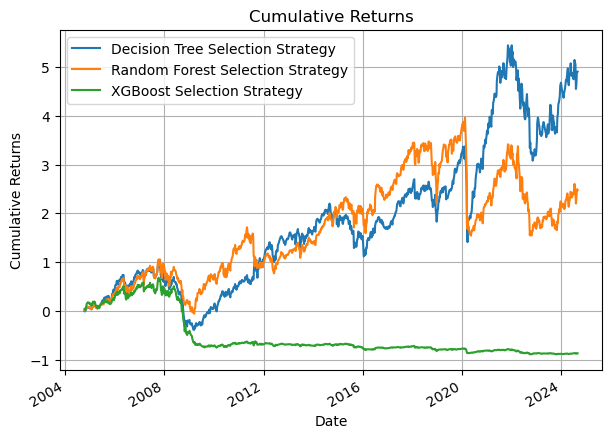

In [ ]:
UNIVERSE = 'broad_asset'
ASSETS = ['Asset ' + str(i) for i in range(1, 12)]

# Decision Tree Backtest
decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':None}, base_per='2004-04-20', update_freq=26)
decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='broad_assets_weekly_rets')
decision_tree_backtest.compute_lookbacks()
decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
decision_tree_backtest.record_predictions(assets=ASSETS)
decision_tree_backtest.calc_strat_rets(strat_name = 'Decision Tree Selection', selection='classifier', weighting='equal')

# Random Forest Backtest
random_forest_backtest = Backtest(model={'model':RandomForestClassifier(n_jobs=-1), 'dim_red':None}, base_per='2004-04-20', update_freq=26)
random_forest_backtest.returns = decision_tree_backtest.returns
random_forest_backtest.lookbacks = decision_tree_backtest.lookbacks
random_forest_backtest.assets = decision_tree_backtest.assets
random_forest_backtest.target = decision_tree_backtest.target
random_forest_backtest.dates_inter = decision_tree_backtest.dates_inter
random_forest_backtest.record_predictions(assets=ASSETS)
random_forest_backtest.calc_strat_rets(strat_name = 'Random Forest Selection', selection='classifier', weighting='equal')

# XGBoost Backtest
xgboost_backtest = Backtest(model={'model':XGBClassifier(n_jobs=-1), 'dim_red':None}, base_per='2004-04-20', update_freq=26)
xgboost_backtest.returns = decision_tree_backtest.returns
xgboost_backtest.lookbacks = decision_tree_backtest.lookbacks
xgboost_backtest.assets = decision_tree_backtest.assets
xgboost_backtest.target = decision_tree_backtest.target
xgboost_backtest.dates_inter = decision_tree_backtest.dates_inter
xgboost_backtest.record_predictions(assets=ASSETS)
xgboost_backtest.calc_strat_rets(strat_name = 'XGBoost Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([decision_tree_backtest.strat_rets, random_forest_backtest.strat_rets, xgboost_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Decision Tree Selection Strategy,Random Forest Selection Strategy,XGBoost Selection Strategy
Annualized Mean,0.1318,0.1114,0.1072
Annualized Vol,0.1834,0.1644,0.1801
Annualized Sharpe,0.7188,0.6776,0.5950
Min,-0.2083,-0.1872,-0.2749
Max,0.1941,0.1583,0.1757
Skewness,-0.1245,-0.6166,-0.6755
Excess Kurtosis,2.5404,2.1232,4.4202
Historical VaR (5.00%),-0.0692,-0.0626,-0.0668
Annualized Historical VaR (5.00%),-0.2396,-0.2168,-0.2314
Historical CVaR (5.00%),-0.1111,-0.1041,-0.1136


None

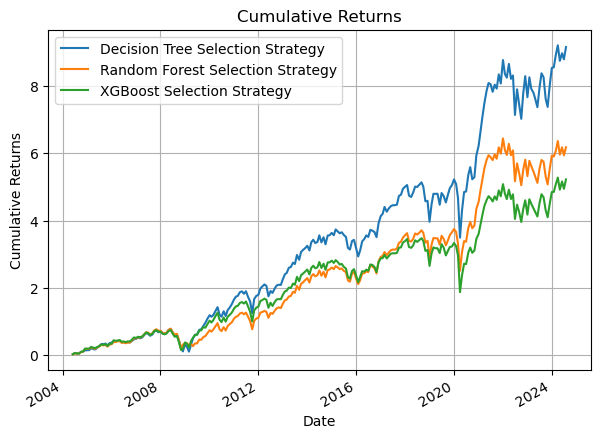

In [ ]:
# Housekeeping
# del decision_tree_backtest, random_forest_backtest, xgboost_backtest, all_rets

# Equity Domestic Asset Universe
UNIVERSE = 'equity_domestic'
ASSETS = ['Asset ' + str(i) for i in range(1, 47)]

# Decision Tree Backtest
decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':None}, base_per='2004-04-10', update_freq=6)
decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_domestic_monthly_rets')
decision_tree_backtest.compute_lookbacks(data_freq='monthly')
decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
decision_tree_backtest.record_predictions(assets=ASSETS)
decision_tree_backtest.calc_strat_rets(strat_name = 'Decision Tree Selection', selection='classifier', weighting='equal')

# Random Forest Backtest
random_forest_backtest = Backtest(model={'model':RandomForestClassifier(n_jobs=-1), 'dim_red':None}, base_per='2004-04-10', update_freq=6)
random_forest_backtest.returns = decision_tree_backtest.returns
random_forest_backtest.lookbacks = decision_tree_backtest.lookbacks
random_forest_backtest.assets = decision_tree_backtest.assets
random_forest_backtest.target = decision_tree_backtest.target
random_forest_backtest.dates_inter = decision_tree_backtest.dates_inter
random_forest_backtest.record_predictions(assets=ASSETS)
random_forest_backtest.calc_strat_rets(strat_name = 'Random Forest Selection', selection='classifier', weighting='equal')

# XGBoost Backtest
xgboost_backtest = Backtest(model={'model':XGBClassifier(n_jobs=-1), 'dim_red':None}, base_per='2004-04-10', update_freq=6)
xgboost_backtest.returns = decision_tree_backtest.returns
xgboost_backtest.lookbacks = decision_tree_backtest.lookbacks
xgboost_backtest.assets = decision_tree_backtest.assets
xgboost_backtest.target = decision_tree_backtest.target
xgboost_backtest.dates_inter = decision_tree_backtest.dates_inter
xgboost_backtest.record_predictions(assets=ASSETS)
xgboost_backtest.calc_strat_rets(strat_name = 'XGBoost Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([decision_tree_backtest.strat_rets, random_forest_backtest.strat_rets, xgboost_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

Completed predictions for period 1 of 32
Completed predictions for period 2 of 32
Completed predictions for period 3 of 32
Completed predictions for period 4 of 32
Completed predictions for period 5 of 32
Completed predictions for period 6 of 32
Completed predictions for period 7 of 32
Completed predictions for period 8 of 32
Completed predictions for period 9 of 32
Completed predictions for period 10 of 32
Completed predictions for period 11 of 32
Completed predictions for period 12 of 32
Completed predictions for period 13 of 32
Completed predictions for period 14 of 32
Completed predictions for period 15 of 32
Completed predictions for period 16 of 32
Completed predictions for period 17 of 32
Completed predictions for period 18 of 32
Completed predictions for period 19 of 32
Completed predictions for period 20 of 32
Completed predictions for period 21 of 32
Completed predictions for period 22 of 32
Completed predictions for period 23 of 32
Completed predictions for period 24 of 32
C

,Decision Tree Selection Strategy,Random Forest Selection Strategy,XGBoost Selection Strategy
Annualized Mean,0.0886,0.1205,0.0985
Annualized Vol,0.1889,0.1676,0.1816
Annualized Sharpe,0.4691,0.7189,0.5424
Min,-0.2332,-0.1698,-0.2528
Max,0.1415,0.1660,0.1418
Skewness,-0.6327,-0.2255,-0.7331
Excess Kurtosis,2.0662,1.3519,3.3040
Historical VaR (5.00%),-0.0892,-0.0668,-0.0668
Annualized Historical VaR (5.00%),-0.3089,-0.2315,-0.2315
Historical CVaR (5.00%),-0.1279,-0.1023,-0.1202


None

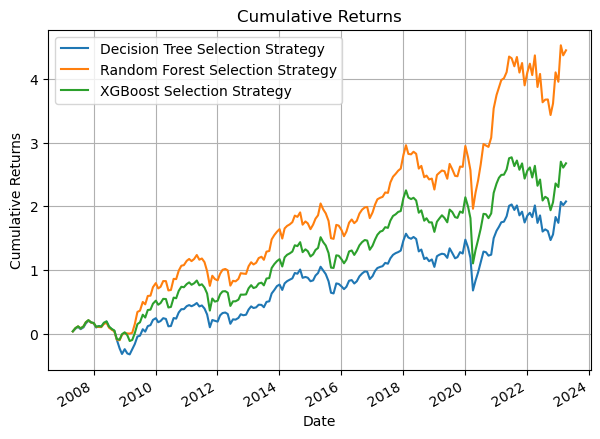

In [ ]:
# Housekeeping
del decision_tree_backtest, random_forest_backtest, xgboost_backtest, all_rets

# Equity Global Asset Universe
UNIVERSE = 'equity_global'
ASSETS = ['Asset ' + str(i) for i in range(1, 53)]

# Decision Tree Backtest
decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':None}, base_per='2007-04-10', update_freq=6)
decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_global_monthly_rets')
decision_tree_backtest.compute_lookbacks(data_freq='monthly')
decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
decision_tree_backtest.record_predictions(assets=ASSETS)
decision_tree_backtest.calc_strat_rets(strat_name = 'Decision Tree Selection', selection='classifier', weighting='equal')

# Random Forest Backtest
random_forest_backtest = Backtest(model={'model':RandomForestClassifier(n_jobs=-1), 'dim_red':None}, base_per='2007-04-10', update_freq=6)
random_forest_backtest.returns = decision_tree_backtest.returns
random_forest_backtest.lookbacks = decision_tree_backtest.lookbacks
random_forest_backtest.assets = decision_tree_backtest.assets
random_forest_backtest.target = decision_tree_backtest.target
random_forest_backtest.dates_inter = decision_tree_backtest.dates_inter
random_forest_backtest.record_predictions(assets=ASSETS)
random_forest_backtest.calc_strat_rets(strat_name = 'Random Forest Selection', selection='classifier', weighting='equal')

# XGBoost Backtest
xgboost_backtest = Backtest(model={'model':XGBClassifier(n_jobs=-1), 'dim_red':None}, base_per='2007-04-10', update_freq=6)
xgboost_backtest.returns = decision_tree_backtest.returns
xgboost_backtest.lookbacks = decision_tree_backtest.lookbacks
xgboost_backtest.assets = decision_tree_backtest.assets
xgboost_backtest.target = decision_tree_backtest.target
xgboost_backtest.dates_inter = decision_tree_backtest.dates_inter
xgboost_backtest.record_predictions(assets=ASSETS)
xgboost_backtest.calc_strat_rets(strat_name = 'XGBoost Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([decision_tree_backtest.strat_rets, random_forest_backtest.strat_rets, xgboost_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

## Dimension Reduction

### **Principal Components Analysis (PCA)**

**Core Concepts:**

**Dimensionality Reduction:** PCA is a statistical technique used to reduce the number of features in a dataset while retaining as much variability as possible. It does this by transforming the original features into a smaller set of uncorrelated components called principal components.

**Principal Components:** These are linear combinations of the original features that capture the maximum variance in the data. The first principal component captures the most variance, the second captures the next most variance, and so on.

**Orthogonality:** The principal components are orthogonal (uncorrelated) to each other, ensuring they represent distinct information.

**Eigenvectors and Eigenvalues:** PCA computes eigenvectors and eigenvalues of the covariance matrix of the data. The eigenvectors determine the direction of the principal components, and the eigenvalues indicate the amount of variance explained by each component.

**Projection:** The data is projected onto the new principal component axes, resulting in a lower-dimensional representation of the data.

**Advantages:**

- *Reduced Dimensionality:* PCA simplifies high-dimensional data, making it easier to visualize and analyze.
- *Noise Reduction:* By focusing on the principal components with the most variance, PCA often filters out noise and less significant variability.
- *Improved Model Performance:* Reducing dimensionality can improve the performance of machine learning algorithms by reducing overfitting and computation time.

**Disadvantages:**

- *Loss of Interpretability:* The transformed features (principal components) are linear combinations of the original features, making them harder to interpret.
- *Assumes Linearity:* PCA captures only linear relationships in the data and may not perform well with non-linear structures.
- *Variance-Only Focus:* PCA assumes that components with high variance are the most important, which may not always align with the specific goals of a task.

**Main Parameters:**

- `n_components`: The number of principal components to keep. This can be an integer or a float (as a percentage of variance to retain).


### **Linear Discriminant Analysis**

**Core Concepts:**

**Supervised Dimensionality Reduction:** LDA is a linear technique used to reduce the dimensionality of data while preserving as much class separability as possible. Unlike PCA, which is unsupervised, LDA utilizes class labels to maximize the separation between categories.

**Maximizing Class Separability:** LDA works by finding the linear combinations of features (discriminants) that best separate the classes in the dataset.

**Scatter Matrices:** LDA computes within-class scatter and between-class scatter matrices. The goal is to maximize the ratio of between-class variance to within-class variance.

**Projection:** The data is projected onto a lower-dimensional space defined by the linear discriminants. The number of discriminants is at most the smaller of `n_classes - 1` or `n_features`.

**Advantages:**

- *Class Separation:* LDA ensures that the projected components maximize class separability, making it highly useful for classification tasks.
- *Dimensionality Reduction:* By projecting data into a lower-dimensional space, LDA reduces computation and storage requirements while retaining discriminative information.
- *Works Well with Linear Boundaries:* LDA performs effectively when the relationship between classes is approximately linear.

**Disadvantages:**

- *Linearity Assumption:* LDA assumes that the features are linearly separable, which limits its effectiveness for non-linear problems.
- *Gaussian Distribution Assumption:* LDA assumes that the features for each class follow a Gaussian distribution, which might not hold true for all datasets.
- *Sensitive to Outliers:* Outliers can significantly affect the scatter matrices and impact the quality of the linear discriminants.

**Main Parameters:**

- `n_components`: The number of dimensions to project the data onto. This is limited to `n_classes - 1`.


### **Neighborhood Components Analysis**

**Core Concepts:**

**Supervised Dimensionality Reduction:** NCA is a supervised learning technique designed to reduce dimensionality while improving the performance of nearest-neighbor classification. It learns a transformation matrix to project data into a lower-dimensional space.

**Metric Learning:** NCA aims to learn a distance metric that increases the probability of correctly classifying data points by their nearest neighbors in the transformed space.

**Optimization Objective:** NCA maximizes a stochastic neighbor assignment objective, ensuring that points from the same class are closer together in the projected space.

**Projection:** The method finds a linear transformation of the input data that enhances class separability in the nearest-neighbor framework.

**Advantages:**

- *Improved Classification:* NCA is tailored to optimize nearest-neighbor classification, often leading to better performance in the reduced space.
- *Flexibility:* It is effective in situations where the relationships between classes are non-linear, as the transformation can reveal useful structures.
- *No Assumptions on Data Distribution:* NCA does not assume any specific distribution for the features, making it versatile across various datasets.

**Disadvantages:**

- *Computational Cost:* The optimization process can be computationally intensive, especially for large datasets with many features.
- *Overfitting:* Without regularization, NCA may overfit the training data, particularly when the dimensionality of the transformed space is high.
- *Sensitivity to Initialization:* The quality of the learned transformation may depend on the initialization of the optimization process.

**Main Parameters:**

- `n_components`: The number of dimensions to project the data onto. Determines the size of the reduced space.
- `init`: The initialization of the transformation matrix. Options include 'random', 'pca', or a user-provided matrix.
- `random_state`: Controls the randomness of the optimization process for reproducibility.
- `reg_param`: The regularization parameter to prevent overfitting by penalizing large values in the transformation matrix.

To analyze the effects of these dimension reduction techniques, we will take the simplest model from above--the Decision Tree Classifier--and observe how each of these techniques affects the strength of the model for each asset universe.

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,PCA Decision Tree Selection Strategy,LDA Decision Tree Selection Strategy,NCA Decision Tree Selection Strategy
Annualized Mean,0.1305,0.0198,0.1103
Annualized Vol,0.2656,0.2591,0.2628
Annualized Sharpe,0.4913,0.0765,0.4199
Min,-0.2372,-0.2600,-0.2131
Max,0.3076,0.2754,0.3353
Skewness,0.2732,-0.6698,0.2436
Excess Kurtosis,9.6902,10.1545,11.6345
Historical VaR (5.00%),-0.0529,-0.0540,-0.0536
Annualized Historical VaR (5.00%),-0.3815,-0.3891,-0.3868
Historical CVaR (5.00%),-0.0875,-0.0927,-0.0881


None

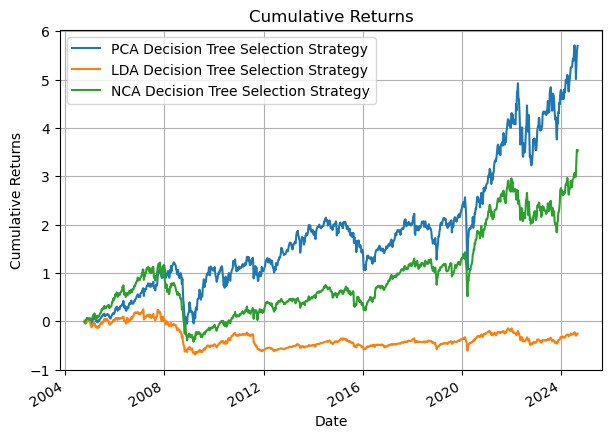

In [ ]:
# Housekeeping
del decision_tree_backtest, random_forest_backtest, xgboost_backtest, all_rets

UNIVERSE = 'broad_asset'
ASSETS = ['Asset ' + str(i) for i in range(1, 12)]

# Principal Components Decision Tree Backtest
pca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':PCA(n_components=0.975)}, base_per='2004-04-20', update_freq=26)
pca_decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='broad_assets_weekly_rets')
pca_decision_tree_backtest.compute_lookbacks()
pca_decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
pca_decision_tree_backtest.record_predictions(assets=ASSETS)
pca_decision_tree_backtest.calc_strat_rets(strat_name = 'PCA Decision Tree Selection', selection='classifier', weighting='equal')

# Linear Discriminant Analysis Decision Tree Selection Backtest
lda_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':LinearDiscriminantAnalysis()}, base_per='2004-04-20', update_freq=26)
lda_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
lda_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
lda_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
lda_decision_tree_backtest.target = pca_decision_tree_backtest.target
lda_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
lda_decision_tree_backtest.record_predictions(assets=ASSETS)
lda_decision_tree_backtest.calc_strat_rets(strat_name = 'LDA Decision Tree Selection', selection='classifier', weighting='equal')

# Neighborhood Components Decision Tree Selection Backtest
nca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':NeighborhoodComponentsAnalysis(init='auto', max_iter=30)}, base_per='2004-04-20', update_freq=26)
nca_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
nca_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
nca_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
nca_decision_tree_backtest.target = pca_decision_tree_backtest.target
nca_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
nca_decision_tree_backtest.record_predictions(assets=ASSETS)
nca_decision_tree_backtest.calc_strat_rets(strat_name = 'NCA Decision Tree Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([pca_decision_tree_backtest.strat_rets, lda_decision_tree_backtest.strat_rets, nca_decision_tree_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,PCA Decision Tree Selection Strategy,LDA Decision Tree Selection Strategy,NCA Decision Tree Selection Strategy
Annualized Mean,0.1211,0.1096,0.1272
Annualized Vol,0.1926,0.1882,0.1847
Annualized Sharpe,0.6288,0.5824,0.6891
Min,-0.2663,-0.1803,-0.2692
Max,0.1921,0.2313,0.2117
Skewness,-0.7645,-0.0011,-0.4104
Excess Kurtosis,3.5363,2.6827,4.2922
Historical VaR (5.00%),-0.0748,-0.0766,-0.0698
Annualized Historical VaR (5.00%),-0.2592,-0.2655,-0.2418
Historical CVaR (5.00%),-0.1313,-0.1181,-0.1134


None

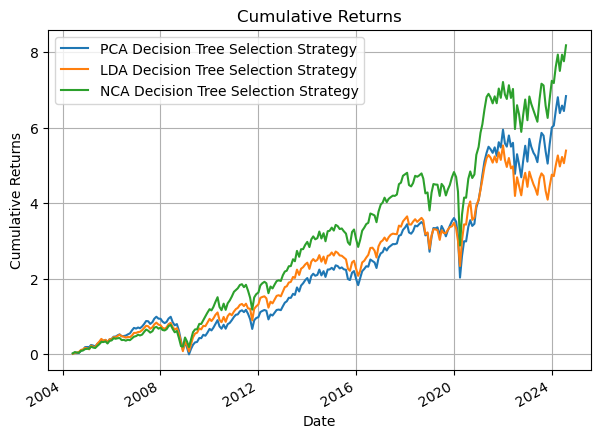

In [ ]:
# Housekeeping
del pca_decision_tree_backtest, lda_decision_tree_backtest, nca_decision_tree_backtest, all_rets

UNIVERSE = 'equity_domestic'
ASSETS = ['Asset ' + str(i) for i in range(1, 47)]

# Principal Components Decision Tree Backtest
pca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':PCA(n_components=0.975)}, base_per='2004-04-20', update_freq=6)
pca_decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_domestic_monthly_rets')
pca_decision_tree_backtest.compute_lookbacks(data_freq='monthly')
pca_decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
pca_decision_tree_backtest.record_predictions(assets=ASSETS)
pca_decision_tree_backtest.calc_strat_rets(strat_name = 'PCA Decision Tree Selection', selection='classifier', weighting='equal')

# Linear Discriminant Analysis Decision Tree Selection Backtest
lda_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':LinearDiscriminantAnalysis()}, base_per='2004-04-20', update_freq=6)
lda_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
lda_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
lda_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
lda_decision_tree_backtest.target = pca_decision_tree_backtest.target
lda_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
lda_decision_tree_backtest.record_predictions(assets=ASSETS)
lda_decision_tree_backtest.calc_strat_rets(strat_name = 'LDA Decision Tree Selection', selection='classifier', weighting='equal')

# Neighborhood Components Decision Tree Selection Backtest
nca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':NeighborhoodComponentsAnalysis(init='auto', max_iter=30)}, base_per='2004-04-20', update_freq=6)
nca_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
nca_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
nca_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
nca_decision_tree_backtest.target = pca_decision_tree_backtest.target
nca_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
nca_decision_tree_backtest.record_predictions(assets=ASSETS)
nca_decision_tree_backtest.calc_strat_rets(strat_name = 'NCA Decision Tree Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([pca_decision_tree_backtest.strat_rets, lda_decision_tree_backtest.strat_rets, nca_decision_tree_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

Completed predictions for period 1 of 32
Completed predictions for period 2 of 32
Completed predictions for period 3 of 32
Completed predictions for period 4 of 32
Completed predictions for period 5 of 32
Completed predictions for period 6 of 32
Completed predictions for period 7 of 32
Completed predictions for period 8 of 32
Completed predictions for period 9 of 32
Completed predictions for period 10 of 32
Completed predictions for period 11 of 32
Completed predictions for period 12 of 32
Completed predictions for period 13 of 32
Completed predictions for period 14 of 32
Completed predictions for period 15 of 32
Completed predictions for period 16 of 32
Completed predictions for period 17 of 32
Completed predictions for period 18 of 32
Completed predictions for period 19 of 32
Completed predictions for period 20 of 32
Completed predictions for period 21 of 32
Completed predictions for period 22 of 32
Completed predictions for period 23 of 32
Completed predictions for period 24 of 32
C

,PCA Decision Tree Selection Strategy,LDA Decision Tree Selection Strategy,NCA Decision Tree Selection Strategy
Annualized Mean,0.0972,0.0655,0.0931
Annualized Vol,0.1963,0.1899,0.1891
Annualized Sharpe,0.4951,0.3447,0.4923
Min,-0.2079,-0.2074,-0.2595
Max,0.1763,0.1587,0.1415
Skewness,-0.3471,-0.6445,-0.7360
Excess Kurtosis,1.9142,2.1211,2.8960
Historical VaR (5.00%),-0.0833,-0.0896,-0.0815
Annualized Historical VaR (5.00%),-0.2886,-0.3104,-0.2822
Historical CVaR (5.00%),-0.1304,-0.1331,-0.1273


None

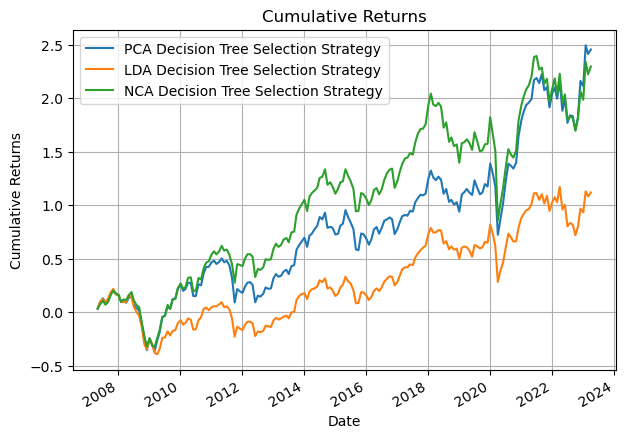

In [ ]:
# Housekeeping
del pca_decision_tree_backtest, lda_decision_tree_backtest, nca_decision_tree_backtest, all_rets

UNIVERSE = 'equity_global'
ASSETS = ['Asset ' + str(i) for i in range(1, 53)]

# Principal Components Decision Tree Backtest
pca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(), 'dim_red':PCA(n_components=0.975)}, base_per='2007-04-10', update_freq=6)
pca_decision_tree_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_global_monthly_rets')
pca_decision_tree_backtest.compute_lookbacks(data_freq='monthly')
pca_decision_tree_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
pca_decision_tree_backtest.record_predictions(assets=ASSETS)
pca_decision_tree_backtest.calc_strat_rets(strat_name = 'PCA Decision Tree Selection', selection='classifier', weighting='equal')

# Linear Discriminant Analysis Decision Tree Selection Backtest
lda_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':LinearDiscriminantAnalysis()}, base_per='2007-04-10', update_freq=6)
lda_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
lda_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
lda_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
lda_decision_tree_backtest.target = pca_decision_tree_backtest.target
lda_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
lda_decision_tree_backtest.record_predictions(assets=ASSETS)
lda_decision_tree_backtest.calc_strat_rets(strat_name = 'LDA Decision Tree Selection', selection='classifier', weighting='equal')

# Neighborhood Components Decision Tree Selection Backtest
nca_decision_tree_backtest = Backtest(model={'model':DecisionTreeClassifier(n_jobs=-1), 'dim_red':NeighborhoodComponentsAnalysis(init='auto', max_iter=30)}, base_per='2007-04-10', update_freq=6)
nca_decision_tree_backtest.returns = pca_decision_tree_backtest.returns
nca_decision_tree_backtest.lookbacks = pca_decision_tree_backtest.lookbacks
nca_decision_tree_backtest.assets = pca_decision_tree_backtest.assets
nca_decision_tree_backtest.target = pca_decision_tree_backtest.target
nca_decision_tree_backtest.dates_inter = pca_decision_tree_backtest.dates_inter
nca_decision_tree_backtest.record_predictions(assets=ASSETS)
nca_decision_tree_backtest.calc_strat_rets(strat_name = 'NCA Decision Tree Selection', selection='classifier', weighting='equal')

# Comparison
all_rets = pd.concat([pca_decision_tree_backtest.strat_rets, lda_decision_tree_backtest.strat_rets, nca_decision_tree_backtest.strat_rets], axis=1)
display(calc_summary_statistics(all_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(all_rets))

It's worth pointing out that the levels achieved by the PCA and NCA pre-processing steps do improve the performance of the classifiers. A fuller summary of this will be provided below.

---
# Hyperparameter Tuning

## Target Variable
We consider a few different possible definitions of our target variable for training the classifier--positive vs. negative returns, and returns exceeding some higher threshold.

### Positive vs. Negative Returns
1 = Positive Return (> 0)

0 = Negative Return (< 0)

### Returns exceeding a threshold

Returns exceeding the mean return of all assets up to a point in time?
* 1 = Return above mean across all assets up to training date ($r_t^i > \mu_t$)
* 0 otherwise

Returns exceed the first standard deviation toward the upside?
* 1 = Return above the 1-standard deviation upside ($r_t^i > \mu_t + \sigma_t$)
* 0 otherwise

**Note:** Because we are inherently introducing imbalance to the classes of the target variable, we will pass the `class_weight='balanced'` parameter to the model used for this example.

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Simple Threshold Training Strategy,Global Mean Threshold Training Strategy,Asset Mean Threshold Training Strategy,Global Standard Deviation Threshold Training Strategy,Asset Standard Deviation Threshold Training Strategy
Annualized Mean,0.0268,0.0243,0.0206,-0.0362,-0.0425
Annualized Vol,0.1158,0.1319,0.1241,0.1500,0.1253
Annualized Sharpe,0.2314,0.1845,0.1663,-0.2416,-0.3392
Min,-0.2252,-0.2197,-0.2392,-0.3352,-0.1899
Max,0.1604,0.2611,0.2431,0.2547,0.1931
Skewness,-0.6063,0.2543,-0.1710,-0.6206,-0.6287
Excess Kurtosis,5.0315,7.9690,7.3056,8.0612,5.5625
Historical VaR (5.00%),-0.0508,-0.0573,-0.0561,-0.0826,-0.0626
Annualized Historical VaR (5.00%),-0.1760,-0.1986,-0.1943,-0.2863,-0.2167
Historical CVaR (5.00%),-0.0816,-0.0906,-0.0878,-0.1199,-0.1013


None

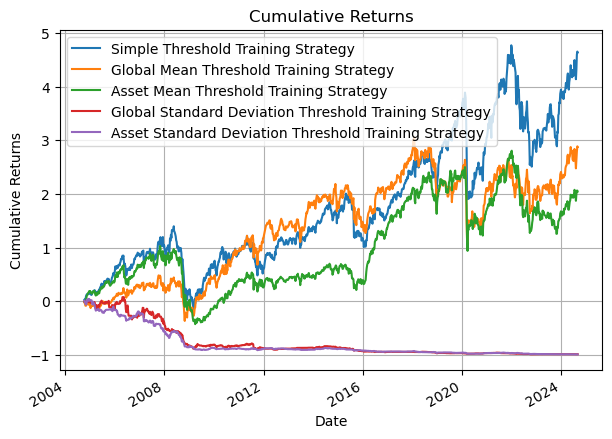

In [ ]:
# Run a test where we modify the target variable by considering those returns exceeding some threshold
# Include a demonstration of how the dataset becomes unbalanced when we do this, and discuss tactics for mitigating this problem.

# Housekeeping
del pca_decision_tree_backtest, lda_decision_tree_backtest, nca_decision_tree_backtest, all_rets

UNIVERSE = 'broad_asset'
ASSETS = ['Asset ' + str(i) for i in range(1, 12)]

# Setting Up backtest with simplest threshold
threshold_backtest = Backtest(model={'model':DecisionTreeClassifier(class_weight='balanced', n_jobs=-1), 'dim_red': None}, base_per='2004-04-20', update_freq=26)
threshold_backtest.read_returns(data_path=DATA_PATH, universe_returns='broad_assets_weekly_rets')
threshold_backtest.compute_lookbacks(data_freq='weekly')
threshold_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Simple Threshold Training', selection='classifier', weighting='equal')

# Adding different thresholds - Global Mean, Asset Mean, Global Standard Deviation, Asset Standard Deviation
target = threshold_backtest.returns.shift(-1).dropna()
target = target.loc[threshold_backtest.dates_inter]

threshold_backtest.target = Backtest.set_targets(target, method='global_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='global_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Standard Deviation Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Standard Deviation Threshold Training', selection='classifier', weighting='equal')

# Comparison
display(calc_summary_statistics(threshold_backtest.strat_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(threshold_backtest.strat_rets))

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Simple Threshold Training Strategy,Global Mean Threshold Training Strategy,Asset Mean Threshold Training Strategy,Global Standard Deviation Threshold Training Strategy,Asset Standard Deviation Threshold Training Strategy
Annualized Mean,0.1282,0.1222,0.1070,0.0720,0.0727
Annualized Vol,0.1899,0.1872,0.1911,0.1899,0.2090
Annualized Sharpe,0.6753,0.6528,0.5600,0.3791,0.3480
Min,-0.2736,-0.2545,-0.3474,-0.2409,-0.2535
Max,0.1971,0.1909,0.1924,0.2297,0.2309
Skewness,-0.4726,-0.4801,-0.9466,-0.4410,-0.0026
Excess Kurtosis,4.0401,3.1823,7.4356,2.7491,3.3099
Historical VaR (5.00%),-0.0709,-0.0710,-0.0680,-0.0819,-0.0855
Annualized Historical VaR (5.00%),-0.2456,-0.2460,-0.2357,-0.2837,-0.2963
Historical CVaR (5.00%),-0.1177,-0.1165,-0.1169,-0.1227,-0.1380


None

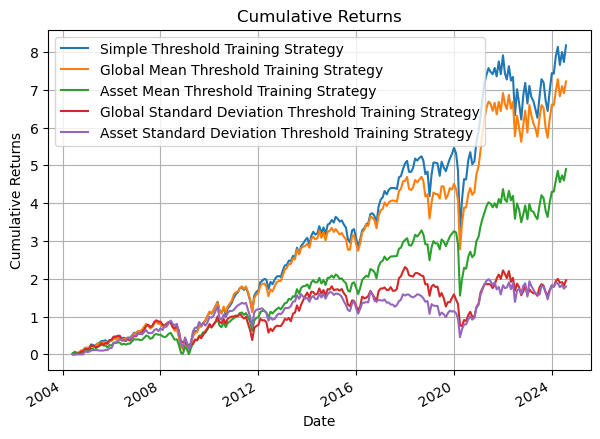

In [ ]:
# Housekeeping
del threshold_backtest

UNIVERSE = 'equity_domestic'
ASSETS = ['Asset ' + str(i) for i in range(1, 47)]

# Setting Up backtest with simplest threshold
threshold_backtest = Backtest(model={'model':DecisionTreeClassifier(class_weight='balanced', n_jobs=-1), 'dim_red': None}, base_per='2004-04-10', update_freq=6)
threshold_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_domestic_monthly_rets')
threshold_backtest.compute_lookbacks(data_freq='monthly')
threshold_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Simple Threshold Training', selection='classifier', weighting='equal')

# Adding different thresholds - Global Mean, Asset Mean, Global Standard Deviation, Asset Standard Deviation
target = threshold_backtest.returns.shift(-1).dropna()
target = target.loc[threshold_backtest.dates_inter]

threshold_backtest.target = Backtest.set_targets(target, method='global_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='global_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Standard Deviation Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Standard Deviation Threshold Training', selection='classifier', weighting='equal')

# Comparison
display(calc_summary_statistics(threshold_backtest.strat_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(threshold_backtest.strat_rets))

Completed predictions for period 1 of 32
Completed predictions for period 2 of 32
Completed predictions for period 3 of 32
Completed predictions for period 4 of 32
Completed predictions for period 5 of 32
Completed predictions for period 6 of 32
Completed predictions for period 7 of 32
Completed predictions for period 8 of 32
Completed predictions for period 9 of 32
Completed predictions for period 10 of 32
Completed predictions for period 11 of 32
Completed predictions for period 12 of 32
Completed predictions for period 13 of 32
Completed predictions for period 14 of 32
Completed predictions for period 15 of 32
Completed predictions for period 16 of 32
Completed predictions for period 17 of 32
Completed predictions for period 18 of 32
Completed predictions for period 19 of 32
Completed predictions for period 20 of 32
Completed predictions for period 21 of 32
Completed predictions for period 22 of 32
Completed predictions for period 23 of 32
Completed predictions for period 24 of 32
C

,Simple Threshold Training Strategy,Global Mean Threshold Training Strategy,Asset Mean Threshold Training Strategy,Global Standard Deviation Threshold Training Strategy,Asset Standard Deviation Threshold Training Strategy
Annualized Mean,0.0899,0.0900,0.0774,0.0850,0.0285
Annualized Vol,0.1956,0.1936,0.2111,0.2477,0.2088
Annualized Sharpe,0.4597,0.4649,0.3669,0.3431,0.1364
Min,-0.2296,-0.2589,-0.2416,-0.2555,-0.2021
Max,0.1652,0.1204,0.2331,0.2155,0.2117
Skewness,-0.6561,-0.9740,-0.5572,-0.2776,-0.0337
Excess Kurtosis,2.4573,2.8516,3.3259,1.5934,1.6636
Historical VaR (5.00%),-0.0901,-0.0852,-0.0869,-0.1138,-0.1027
Annualized Historical VaR (5.00%),-0.3120,-0.2951,-0.3010,-0.3941,-0.3559
Historical CVaR (5.00%),-0.1374,-0.1361,-0.1507,-0.1650,-0.1343


None

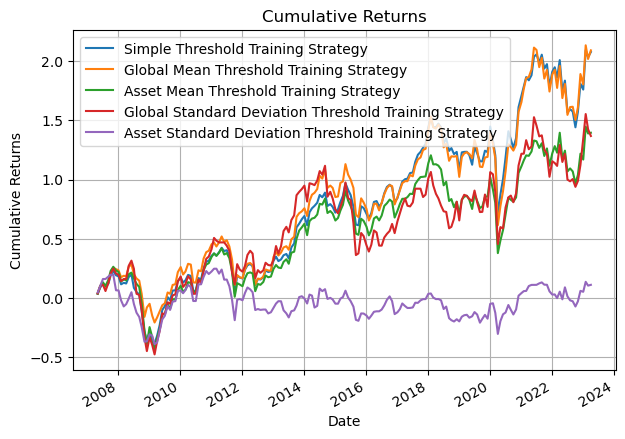

In [4]:
# Housekeeping
# del threshold_backtest

UNIVERSE = 'equity_global'
ASSETS = ['Asset ' + str(i) for i in range(1, 53)]

# Setting Up backtest with simplest threshold
threshold_backtest = Backtest(model={'model':DecisionTreeClassifier(class_weight='balanced'), 'dim_red': None}, base_per='2007-04-10', update_freq=6)
threshold_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_global_monthly_rets')
threshold_backtest.compute_lookbacks(data_freq='monthly')
threshold_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Simple Threshold Training', selection='classifier', weighting='equal')

# Adding different thresholds - Global Mean, Asset Mean, Global Standard Deviation, Asset Standard Deviation
target = threshold_backtest.returns.shift(-1).dropna()
target = target.loc[threshold_backtest.dates_inter]

threshold_backtest.target = Backtest.set_targets(target, method='global_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_mean')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Mean Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='global_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Global Standard Deviation Threshold Training', selection='classifier', weighting='equal')

threshold_backtest.target = Backtest.set_targets(target, method='asset_std')
threshold_backtest.record_predictions(assets=ASSETS)
threshold_backtest.calc_strat_rets(strat_name = 'Asset Standard Deviation Threshold Training', selection='classifier', weighting='equal')

# Comparison
display(calc_summary_statistics(threshold_backtest.strat_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
display(calc_cumulative_returns(threshold_backtest.strat_rets))

It looks like the Global Mean and Asset Mean thresholds could show some promise when coupled with some more robust models such as the Random Forest with PCA or NCA for pre-processing. However, with this simple analysis, no other thresholds provide better performance for the models than the basic threshold that only targets assets with positive returning periods.

## Hyperparameter Grid Search & Cross Validation

### Grid Search Types
* **Grid Search CV:** Exhaustive search of hyperparameters given a defined range of options. This method is more robust if computation speed is of lesser concern.
* **Randomized Search CV:** Search of hyperparemters conducted using random sampling of hyperparameters defined by some distribution. This method is more computationally efficient, but isn't guaranteed to find the optimal combination of hyperparameters.

### Score Evaluation
* Accuracy
* F1-Score

### K-Fold Cross-Validation

**K-fold cross-validation** is a statistical technique used to evaluate the performance of a machine learning model and ensure its ability to generalize to unseen data. It works by splitting the dataset into $k$ equally (or nearly equally) sized subsets, or "folds." Importantly, this cross-validation does not take a time dimension into consideration, but this is not of concern given the construction of our model training setup. The validation process involves the following steps:

#### Steps in K-Fold Cross-Validation:

1. **Splitting the Data**: The dataset is divided into $k$ folds, ensuring that each fold represents the entire dataset's distribution (often using stratified sampling for classification tasks).

2. **Training and Testing**:  
   - The model is trained $k$ times, each time using a different fold as the test set and the remaining $k-1$ folds as the training set.
   - For each iteration, the model is fit to the training set and evaluated on the test set.

3. **Repeating Across Folds**: This process is repeated $k$ times, with each fold used exactly once as the test set.

4. **Aggregating Results**: The performance metrics (e.g., accuracy, precision, recall, F1 score, mean squared error) from each fold are averaged to provide a more reliable estimate of the model's generalization performance.

#### Benefits of K-Fold Cross-Validation:

- **Reduces Bias**: Ensures the model is evaluated on multiple subsets of data, reducing dependency on a single train-test split.

- **Better Generalization Insight**: Provides a more robust estimate of how the model performs on unseen data.

- **Efficient Use of Data**: Every data point is used for both training and testing across the $k$ iterations.

#### Considerations:

- **Computational Cost**: More computationally expensive than a simple train-test split, as the model is trained and tested $k$ times.

- **Choice of $k$**: Common choices for $k$ are 5 or 10, though the choice depends on the dataset size and computational resources.

K-fold cross-validation is widely used for model selection, hyperparameter tuning, and avoiding overfitting. It is especially useful in scenarios with limited data, as it ensures efficient utilization of the entire dataset for both training and testing. We apply it to training below to optimize the possible model choices and identify the best.


In [4]:
# Set up some loops to compile some models with grid-search parameters and compare them
# This section will be very computationally expensive, so share with Sam to run on the server

# Hyperparameters
DIM_RED_PCA_N_COMPONENTS_LIST = [0.95, 0.975, 0.99, None]
DIM_RED_NCA_N_COMPONENTS_LIST = [2, 4, 8, 16, 32]
N_ESTIMATORS_LIST = [10,50,100,500]
MIN_SAMPLES_SPLIT_LIST = [2,10, 30, 50, 100, 200, 300, 700, 1000]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
MAX_DEPTH_LIST = [2, 4, 8, 16, 32, 64, None]
CLASS_WEIGHT_LIST = ['balanced_subsample', 'balanced', None]

# Models, Dimension Reduction Techniques, and parameter grids
decision_tree_params = {'classifier__min_samples_split': MIN_SAMPLES_SPLIT_LIST, 
                        'classifier__max_depth': MAX_DEPTH_LIST,
                        'classifier__class_weight': CLASS_WEIGHT_LIST}
rf_xgb_params = {'classifier__n_estimators': N_ESTIMATORS_LIST, 
                 'classifier__min_samples_split': MIN_SAMPLES_SPLIT_LIST, 
                 'classifier__max_depth': MAX_DEPTH_LIST,
                 'classifier__class_weight': CLASS_WEIGHT_LIST}

models = {'Decision Tree': (DecisionTreeClassifier(random_state=42), decision_tree_params), 
          'Random Forest': (RandomForestClassifier(n_jobs = -1, random_state=42), rf_xgb_params), 
          'XGBoost': (XGBClassifier(n_jobs = -1, random_state=42), rf_xgb_params)}

dim_reds = {'PCA': (PCA(), {'dim_red__n_components': DIM_RED_PCA_N_COMPONENTS_LIST}), 
            'LDA': (LinearDiscriminantAnalysis(), {'dim_red__n_components': [None]})} 
            # 'NCA': (NeighborhoodComponentsAnalysis(init='auto', max_iter=30, warm_start=True, random_state=42), {'dim_red__n_components': DIM_RED_NCA_N_COMPONENTS_LIST})}

# Different Target Thresholds
thresholds = {'Global Mean': 'global_mean', 
              'Asset Mean': 'asset_mean', 
              'Basic': None}


In [ ]:
# del threshold_backtest
# Broad Assets Training Loop
UNIVERSE = 'broad_asset'
ASSETS = ['Asset ' + str(i) for i in range(1, 12)]

broad_backtest = Backtest(model={'model':None, 'dim_red':None}, base_per='2004-04-20', update_freq=26)
broad_backtest.read_returns(data_path=DATA_PATH, universe_returns='broad_assets_weekly_rets')
broad_backtest.compute_lookbacks(data_freq='weekly')
broad_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)

target = broad_backtest.returns.shift(-1).dropna()
target = target.loc[broad_backtest.dates_inter]

i=0
for dr0, dr1 in dim_reds.items():
    for m0, m1 in models.items():
        model = {'model':m1[0], 'dim_red': dr1[0]}
        param_grid = {**m1[1], **dr1[1]}
        broad_backtest.model = Classifier(**model)
        for thresh0, thresh1 in thresholds.items():
            broad_backtest.target = Backtest.set_targets(target, method=thresh1)
            broad_backtest.record_predictions(assets=ASSETS, param_grid=param_grid)
            broad_backtest.predictions.to_excel(f'{ANALYSIS_PATH}{UNIVERSE} {m0}-{dr0} {thresh0} Threshold Predictions.xlsx')
            broad_backtest.calc_strat_rets(strat_name = f'{m0}-{dr0} {thresh0} Threshold', selection='classifier', weighting='equal')
            write_params(data_path=DATA_PATH, file_name='broad_assets_hyperparams.txt', model_name=f'{m0}-{dr0} {thresh0} Threshold', 
                         params_hist=broad_backtest.model._params_hist, universe=UNIVERSE)
            i += 1
            print(f'Finished Strategy {i} of {len(dim_reds)*len(models)*len(thresholds)}')

display(calc_summary_statistics(broad_backtest.strat_rets, annual_factor=52, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
broad_backtest.strat_rets.to_excel(f'{ANALYSIS_PATH}broad_assets_strat_rets.xlsx')

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Decision Tree-PCA Global Mean Threshold Strategy Strategy,Decision Tree-PCA Asset Mean Threshold Strategy Strategy,Decision Tree-PCA Basic Threshold Strategy Strategy,Random Forest-PCA Global Mean Threshold Strategy Strategy,Random Forest-PCA Asset Mean Threshold Strategy Strategy,Random Forest-PCA Basic Threshold Strategy Strategy,XGBoost-PCA Global Mean Threshold Strategy Strategy,XGBoost-PCA Asset Mean Threshold Strategy Strategy,XGBoost-PCA Basic Threshold Strategy Strategy,Decision Tree-LDA Global Mean Threshold Strategy Strategy,Decision Tree-LDA Asset Mean Threshold Strategy Strategy,Decision Tree-LDA Basic Threshold Strategy Strategy,Random Forest-LDA Global Mean Threshold Strategy Strategy,Random Forest-LDA Asset Mean Threshold Strategy Strategy,Random Forest-LDA Basic Threshold Strategy Strategy,XGBoost-LDA Global Mean Threshold Strategy Strategy,XGBoost-LDA Asset Mean Threshold Strategy Strategy,XGBoost-LDA Basic Threshold Strategy Strategy
Annualized Mean,0.1539,0.0894,0.1405,0.1041,0.1290,0.1358,0.0990,0.1620,0.1531,-0.0525,-0.0480,0.0029,-0.0620,-0.0905,-0.0008,-0.0593,-0.0902,-0.0210
Annualized Vol,0.2563,0.2803,0.2407,0.2702,0.2544,0.2450,0.2914,0.2758,0.2369,0.2972,0.2855,0.2615,0.3138,0.2932,0.2758,0.3167,0.3013,0.2677
Annualized Sharpe,0.6005,0.3188,0.5836,0.3851,0.5069,0.5542,0.3397,0.5874,0.6462,-0.1767,-0.1682,0.0111,-0.1976,-0.3086,-0.0028,-0.1874,-0.2993,-0.0786
Min,-0.2295,-0.2049,-0.1976,-0.2067,-0.2096,-0.2415,-0.3351,-0.2058,-0.1976,-0.2721,-0.2502,-0.2417,-0.3084,-0.2661,-0.2507,-0.2721,-0.2721,-0.2507
Max,0.2017,0.3165,0.1982,0.2434,0.2541,0.2001,0.2254,0.3620,0.2098,0.2986,0.3867,0.2621,0.2986,0.3867,0.2621,0.2986,0.3867,0.2633
Skewness,-0.1471,0.4753,-0.0868,-0.2063,-0.1231,-0.3240,-0.5956,0.9472,0.1018,-0.3224,0.1751,-0.1640,-0.2316,0.2318,-0.1210,-0.1210,0.2836,-0.4335
Excess Kurtosis,4.7792,11.8327,5.7546,5.9261,7.7847,8.2775,8.9649,14.6992,6.1004,9.7675,15.7840,10.7626,9.5805,13.9528,10.8337,8.3916,15.3202,10.5122
Historical VaR (5.00%),-0.0522,-0.0593,-0.0465,-0.0584,-0.0512,-0.0479,-0.0612,-0.0535,-0.0468,-0.0650,-0.0596,-0.0552,-0.0703,-0.0669,-0.0560,-0.0677,-0.0654,-0.0549
Annualized Historical VaR (5.00%),-0.3766,-0.4280,-0.3351,-0.4210,-0.3693,-0.3454,-0.4410,-0.3859,-0.3378,-0.4690,-0.4299,-0.3978,-0.5071,-0.4823,-0.4041,-0.4884,-0.4717,-0.3960
Historical CVaR (5.00%),-0.0825,-0.0944,-0.0782,-0.0916,-0.0842,-0.0797,-0.0998,-0.0857,-0.0738,-0.1063,-0.1017,-0.0897,-0.1104,-0.1053,-0.0946,-0.1102,-0.1075,-0.0960


NameError: name 'threshold_backtest' is not defined

None

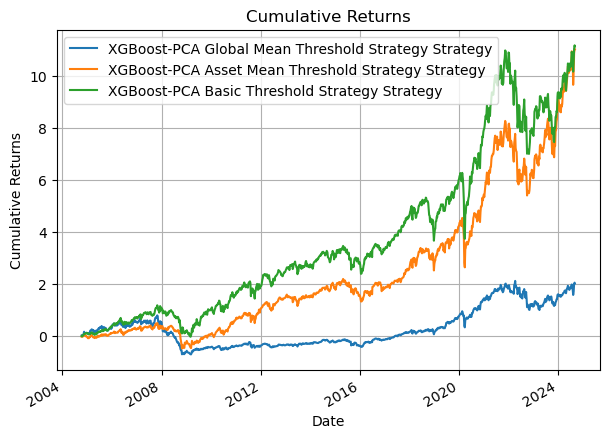

In [11]:
display(calc_cumulative_returns(broad_backtest.strat_rets[['XGBoost-PCA Global Mean Threshold Strategy Strategy', 'XGBoost-PCA Asset Mean Threshold Strategy Strategy', 'XGBoost-PCA Basic Threshold Strategy Strategy']]))

In [18]:
# del broad_backtest
# Equity Domestic Training Loop
UNIVERSE = 'equity_domestic'
ASSETS = ['Asset ' + str(i) for i in range(1, 47)]

eqd_backtest = Backtest(model={'model':None, 'dim_red':None}, base_per='2004-04-10', update_freq=6)
eqd_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_domestic_monthly_rets')
eqd_backtest.compute_lookbacks(data_freq='monthly')
eqd_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)

target = eqd_backtest.returns.shift(-1).dropna()
target = target.loc[eqd_backtest.dates_inter]

i = 0
for dr0, dr1 in dim_reds.items():
    for m0, m1 in models.items():
        model = {'model':m1[0], 'dim_red': dr1[0]}
        param_grid = {**m1[1], **dr1[1]}
        eqd_backtest.model = Classifier(**model)
        for thresh0, thresh1 in thresholds.items():
            eqd_backtest.target = Backtest.set_targets(target, method=thresh1)
            eqd_backtest.record_predictions(assets=ASSETS, param_grid=param_grid)
            eqd_backtest.predictions.to_excel(f'{ANALYSIS_PATH}{UNIVERSE} {m0}-{dr0} {thresh0} Threshold Predictions.xlsx')
            eqd_backtest.calc_strat_rets(strat_name = f'{m0}-{dr0} {thresh0} Threshold', selection='classifier', weighting='equal')
            write_params(data_path=DATA_PATH, file_name='equity_domestic_hyperparams.txt', model_name=f'{m0}-{dr0} {thresh0} Threshold', 
                         params_hist=eqd_backtest.model._params_hist, universe=UNIVERSE)
            i += 1
            print(f'Finished Strategy {i} of {len(dim_reds)*len(models)*len(thresholds)}')

display(calc_summary_statistics(eqd_backtest.strat_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
eqd_backtest.strat_rets.to_excel(f'{ANALYSIS_PATH}equity_domestic_strat_rets.xlsx')

Completed predictions for period 1 of 40
Completed predictions for period 2 of 40
Completed predictions for period 3 of 40
Completed predictions for period 4 of 40
Completed predictions for period 5 of 40
Completed predictions for period 6 of 40
Completed predictions for period 7 of 40
Completed predictions for period 8 of 40
Completed predictions for period 9 of 40
Completed predictions for period 10 of 40
Completed predictions for period 11 of 40
Completed predictions for period 12 of 40
Completed predictions for period 13 of 40
Completed predictions for period 14 of 40
Completed predictions for period 15 of 40
Completed predictions for period 16 of 40
Completed predictions for period 17 of 40
Completed predictions for period 18 of 40
Completed predictions for period 19 of 40
Completed predictions for period 20 of 40
Completed predictions for period 21 of 40
Completed predictions for period 22 of 40
Completed predictions for period 23 of 40
Completed predictions for period 24 of 40
C

,Decision Tree-PCA Global Mean Threshold Strategy,Decision Tree-PCA Asset Mean Threshold Strategy,Decision Tree-PCA Basic Threshold Strategy,Random Forest-PCA Global Mean Threshold Strategy,Random Forest-PCA Asset Mean Threshold Strategy,Random Forest-PCA Basic Threshold Strategy,XGBoost-PCA Global Mean Threshold Strategy,XGBoost-PCA Asset Mean Threshold Strategy,XGBoost-PCA Basic Threshold Strategy,Decision Tree-LDA Global Mean Threshold Strategy,Decision Tree-LDA Asset Mean Threshold Strategy,Decision Tree-LDA Basic Threshold Strategy,Random Forest-LDA Global Mean Threshold Strategy,Random Forest-LDA Asset Mean Threshold Strategy,Random Forest-LDA Basic Threshold Strategy,XGBoost-LDA Global Mean Threshold Strategy,XGBoost-LDA Asset Mean Threshold Strategy,XGBoost-LDA Basic Threshold Strategy
Annualized Mean,0.1122,0.1170,0.1222,0.1251,0.0837,0.1327,0.1116,0.0894,0.1112,0.1060,0.0839,0.1119,0.0986,0.0796,0.1055,0.0978,0.0802,0.1150
Annualized Vol,0.1962,0.1982,0.1919,0.2052,0.1873,0.1842,0.1974,0.1921,0.1834,0.1929,0.1882,0.1781,0.1903,0.1847,0.1577,0.1914,0.1864,0.1798
Annualized Sharpe,0.5715,0.5905,0.6368,0.6099,0.4468,0.7202,0.5656,0.4655,0.6064,0.5494,0.4458,0.6281,0.5182,0.4311,0.6689,0.5109,0.4301,0.6398
Min,-0.2405,-0.2526,-0.2640,-0.2933,-0.2783,-0.2503,-0.2796,-0.1885,-0.2343,-0.1809,-0.1943,-0.1594,-0.1827,-0.1943,-0.1827,-0.2082,-0.1838,-0.1678
Max,0.2254,0.2176,0.2106,0.2683,0.2276,0.1934,0.2177,0.2194,0.1973,0.2028,0.2118,0.2164,0.2022,0.2147,0.1970,0.2092,0.2125,0.2195
Skewness,-0.3334,-0.2186,-0.5800,-0.2465,-0.6231,-0.5232,-0.7039,-0.0590,-0.5268,0.1174,-0.0137,0.1826,0.0813,0.0840,-0.2062,-0.0139,0.1040,0.1249
Excess Kurtosis,3.0521,3.4931,3.9243,5.1553,4.5713,3.4470,3.8207,2.1791,3.3810,2.3740,2.5250,2.6879,2.4982,2.9825,2.6329,2.7997,2.6282,2.5601
Historical VaR (5.00%),-0.0760,-0.0758,-0.0700,-0.0763,-0.0762,-0.0695,-0.0782,-0.0859,-0.0734,-0.0767,-0.0741,-0.0693,-0.0743,-0.0762,-0.0630,-0.0752,-0.0790,-0.0697
Annualized Historical VaR (5.00%),-0.2633,-0.2625,-0.2424,-0.2643,-0.2638,-0.2408,-0.2709,-0.2974,-0.2543,-0.2657,-0.2568,-0.2399,-0.2574,-0.2641,-0.2182,-0.2606,-0.2737,-0.2414
Historical CVaR (5.00%),-0.1281,-0.1257,-0.1248,-0.1291,-0.1235,-0.1178,-0.1339,-0.1237,-0.1230,-0.1164,-0.1186,-0.1052,-0.1158,-0.1152,-0.0959,-0.1164,-0.1152,-0.1060


None

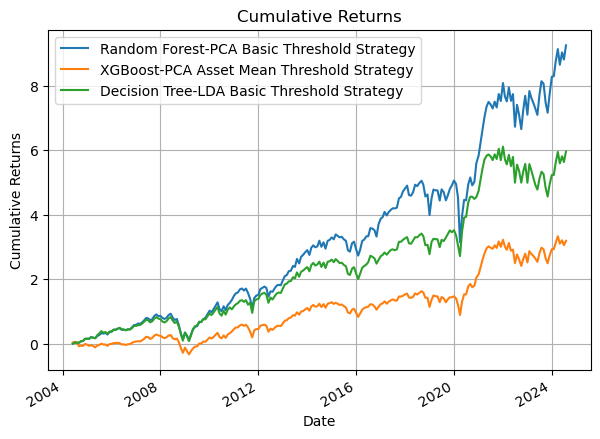

In [5]:
eqd_strat_rets = pd.read_excel(f'{ANALYSIS_PATH}equity_domestic_strat_rets.xlsx', index_col='Date', parse_dates=True)
strats = [
    'Random Forest-PCA Basic Threshold Strategy',
    'XGBoost-PCA Asset Mean Threshold Strategy',
    'Decision Tree-LDA Basic Threshold Strategy'
]
display(calc_cumulative_returns(eqd_strat_rets[strats]))

In [20]:
del eqd_backtest
# Equity Global Training Loop
UNIVERSE = 'equity_global'
ASSETS = ['Asset ' + str(i) for i in range(1, 53)]

eqg_backtest = Backtest(model={'model':None, 'dim_red':None}, base_per='2007-04-10', update_freq=6)
eqg_backtest.read_returns(data_path=DATA_PATH, universe_returns='equity_global_monthly_rets')
eqg_backtest.compute_lookbacks(data_freq='monthly')
eqg_backtest.read_data(data_path=DATA_PATH, assets=ASSETS, universe=UNIVERSE, file_str_func=assets_file_str_func)

target = eqg_backtest.returns.shift(-1).dropna()
target = target.loc[eqg_backtest.dates_inter]

i = 0
for dr0, dr1 in dim_reds.items():
    for m0, m1 in models.items():
        model = {'model':m1[0], 'dim_red': dr1[0]}
        param_grid = {**m1[1], **dr1[1]}
        eqg_backtest.model = Classifier(**model)
        for thresh0, thresh1 in thresholds.items():
            eqg_backtest.target = Backtest.set_targets(target, method=thresh1)
            eqg_backtest.record_predictions(assets=ASSETS, param_grid=param_grid)
            eqg_backtest.predictions.to_excel(f'{ANALYSIS_PATH}{UNIVERSE} {m0}-{dr0} {thresh0} Threshold Predictions.xlsx')
            eqg_backtest.calc_strat_rets(strat_name = f'{m0}-{dr0} {thresh0} Threshold', selection='classifier', weighting='equal')
            write_params(data_path=DATA_PATH, file_name='equity_global_hyperparams.txt', model_name=f'{m0}-{dr0} {thresh0} Threshold', 
                         params_hist=eqg_backtest.model._params_hist, universe=UNIVERSE)
            i += 1
            print(f'Finished Strategy {i} of {len(dim_reds)*len(models)*len(thresholds)}')

display(calc_summary_statistics(eqg_backtest.strat_rets, annual_factor=12, correlations=False, keep_columns=['Annualized Mean',
                                                                                      'Annualized Vol',
                                                                                      'Annualized Sharpe',
                                                                                      'Min',
                                                                                      'Max',
                                                                                      'Skewness',
                                                                                      'Excess Kurtosis',
                                                                                      'Historical VaR',
                                                                                      'Historical CVaR',
                                                                                      'Max Drawdown',
                                                                                      'Peak',
                                                                                      'Bottom',
                                                                                      'Recover',
                                                                                      'Duration (days)']).T)
eqg_backtest.strat_rets.to_excel(f'{ANALYSIS_PATH}equity_global_strat_rets.xlsx')

Completed predictions for period 1 of 32
Completed predictions for period 2 of 32
Completed predictions for period 3 of 32
Completed predictions for period 4 of 32
Completed predictions for period 5 of 32
Completed predictions for period 6 of 32
Completed predictions for period 7 of 32
Completed predictions for period 8 of 32
Completed predictions for period 9 of 32
Completed predictions for period 10 of 32
Completed predictions for period 11 of 32
Completed predictions for period 12 of 32
Completed predictions for period 13 of 32
Completed predictions for period 14 of 32
Completed predictions for period 15 of 32
Completed predictions for period 16 of 32
Completed predictions for period 17 of 32
Completed predictions for period 18 of 32
Completed predictions for period 19 of 32
Completed predictions for period 20 of 32
Completed predictions for period 21 of 32
Completed predictions for period 22 of 32
Completed predictions for period 23 of 32
Completed predictions for period 24 of 32
C

,Decision Tree-PCA Global Mean Threshold Strategy,Decision Tree-PCA Asset Mean Threshold Strategy,Decision Tree-PCA Basic Threshold Strategy,Random Forest-PCA Global Mean Threshold Strategy,Random Forest-PCA Asset Mean Threshold Strategy,Random Forest-PCA Basic Threshold Strategy,XGBoost-PCA Global Mean Threshold Strategy,XGBoost-PCA Asset Mean Threshold Strategy,XGBoost-PCA Basic Threshold Strategy,Decision Tree-LDA Global Mean Threshold Strategy,Decision Tree-LDA Asset Mean Threshold Strategy,Decision Tree-LDA Basic Threshold Strategy,Random Forest-LDA Global Mean Threshold Strategy,Random Forest-LDA Asset Mean Threshold Strategy,Random Forest-LDA Basic Threshold Strategy,XGBoost-LDA Global Mean Threshold Strategy,XGBoost-LDA Asset Mean Threshold Strategy,XGBoost-LDA Basic Threshold Strategy
Annualized Mean,0.0965,0.0557,0.1009,0.0916,0.1076,0.0905,0.1006,0.0938,0.1247,0.0476,0.0598,0.0482,0.0396,0.0554,0.0554,0.0344,0.0580,0.0556
Annualized Vol,0.2031,0.1975,0.1791,0.2039,0.1873,0.1986,0.2081,0.1975,0.1969,0.2112,0.1982,0.1830,0.2104,0.1978,0.1942,0.2085,0.1948,0.1860
Annualized Sharpe,0.4750,0.2823,0.5630,0.4492,0.5744,0.4556,0.4836,0.4748,0.6330,0.2255,0.3017,0.2635,0.1881,0.2801,0.2851,0.1649,0.2976,0.2987
Min,-0.2307,-0.2500,-0.2415,-0.2308,-0.1998,-0.2213,-0.2433,-0.2327,-0.2097,-0.2343,-0.2202,-0.1915,-0.2344,-0.2179,-0.2100,-0.2293,-0.2121,-0.1881
Max,0.1927,0.1512,0.1713,0.1661,0.1571,0.1661,0.2123,0.1683,0.2326,0.1716,0.1733,0.1632,0.1733,0.1711,0.1661,0.1618,0.1720,0.1572
Skewness,-0.6171,-0.8512,-0.6587,-0.5957,-0.2998,-0.6099,-0.4802,-0.3959,-0.0564,-0.5085,-0.4145,-0.5654,-0.5365,-0.4485,-0.4483,-0.5271,-0.4584,-0.4919
Excess Kurtosis,2.8075,3.0902,3.2217,2.2847,1.5446,2.4282,3.2537,1.8798,2.5804,1.4782,1.8019,1.8093,1.3133,1.8614,1.9839,1.4085,1.7995,1.5782
Historical VaR (5.00%),-0.0874,-0.0876,-0.0739,-0.0883,-0.0782,-0.0865,-0.0847,-0.0849,-0.0810,-0.0947,-0.0853,-0.0814,-0.0947,-0.0860,-0.0890,-0.0936,-0.0880,-0.0812
Annualized Historical VaR (5.00%),-0.3029,-0.3033,-0.2561,-0.3059,-0.2708,-0.2996,-0.2934,-0.2941,-0.2807,-0.3282,-0.2953,-0.2820,-0.3282,-0.2978,-0.3081,-0.3243,-0.3047,-0.2813
Historical CVaR (5.00%),-0.1412,-0.1483,-0.1173,-0.1408,-0.1177,-0.1382,-0.1399,-0.1273,-0.1237,-0.1475,-0.1323,-0.1271,-0.1465,-0.1335,-0.1338,-0.1438,-0.1316,-0.1261


None

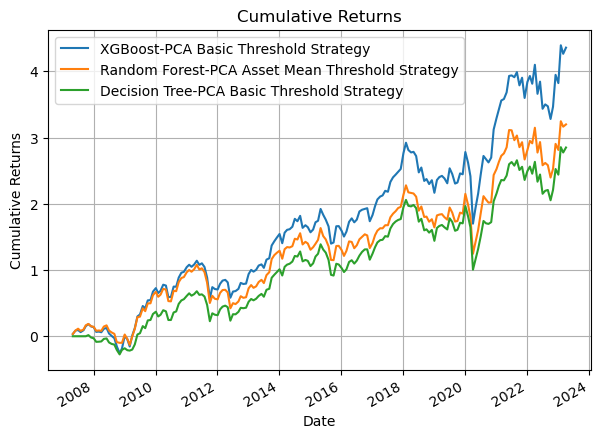

In [6]:
eqg_strat_rets = pd.read_excel(f'{ANALYSIS_PATH}equity_global_strat_rets.xlsx', index_col='Date', parse_dates=True)
strats = [
    'XGBoost-PCA Basic Threshold Strategy',
    'Random Forest-PCA Asset Mean Threshold Strategy',
    'Decision Tree-PCA Basic Threshold Strategy'
]
display(calc_cumulative_returns(eqg_strat_rets[strats]))

---
# Potential Improvements

## Other Models

### Time-Series Models
* **Auto-Regressive Moving Average (ARMA) Model**: ARMA models are specially designed for time-series analysis. These models are particularly powerful for time-series that exhibit auto-correlation, which is not always the case for asset return data. Regardless, it is a model commonly applied to financial returns data.

* **Auto-Regressive Integrated Moving Average (ARIMA) Model**: Same as above, but relaxes the constraint that the data in the time-series needs to be stationary.

* **Vector Auto-Regressive (VAR) Model**: This model goes beyond modeling an individual time-series by trying to model a system of interrelated variables. It extends the concept of the above autoregressive models by handling multiple time-series simultaneously and capturing their relationships. This, however, leads to the number of modeled variables to grow rapidly and makes the model system prone to overfitting.

Some common python libraries for these types of models are `statsmodels` and `sklearn`.

### Neural Networks
* **Convolutional Neural Networks (CNN)**: While CNN's are typically used for computer vision tasks, they can also be applied to time-series analysis. They are useful for short-term horizon forecasts especially if patterns tend to repeat (think: mean-reversion), if a longer-range dependency is being forecast, then different a different model should be adopted (refer below).

* **Recurrent Neural Networks (RNN)**: RNN's are specifically designed for sequential data, like time-series data, and they have the ability to capture temporal dependencies by maintaining a memory of past information. They do this buy maintaining "hidden states" that keep track of information throughout the sequence as it is processed. 

* **Long-Short Term Memory (LSTM) Networks**: LSTM Networks are a special sub-class of RNN's that are designed to better capture "long-term" dependencies. This can be particularly useful for financial time-series data analysis because some data exhibits cycles only over long time intervals.

Some common python libraries for these types of models are `tensorflow` and `pytorch`.

Each of these types of forecasting models could be used to provide reasonable estimates for expected returns in the forthcoming period, which can then be plugged in to a portfolio opimization algorithm for more robust optimization performance out of sample.

## More Diverse Features

In this project, we provide a proof-of-concept using momentum and risk indicators that are exclusively derived from daily return data. This can likely be improved by introducing more diverse feature data on variables that are exogenous to the securities being analyzed.

## Tuning By Asset Class

Improvement of Classifier appeared better when training was focused on a more homogenous asset class (equities). As such, it may be better to bucket training of these models by asset class to improve selection performance.

## Training Window

In our model training, we've only considered using an expanding window of data for classifier training. This approach could be modified by allowing a rolling training window once you reach a certain amount of historical data. This technique would have the effect of allowing the model to "forget" certain regimes in the data that may be considered irrelevant, or overly punitive.

## Collect/Generate More Training Data

While this often difficult with financial and economic data, Machine Learning models often benefit from having larger datasets. A possible solution to this small data problem is to generate synthetic data. This is a process that would require care in properly defining the data generating process of all variables, but could improve the strength of these models.

---
# Playground